# Adapted Attribute Types

**Purpose**: demonstrate using `dj.AttributeAdapter` for convenient storage of arbitrary data types in DataJoint table attributes.

Imagine I want store graph objects of type `networkx.Graph` in the form of edge lists. 

First, let's create a few graphs:

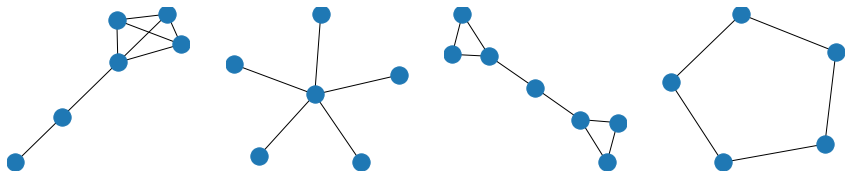

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import networkx as nx
graphs = [nx.lollipop_graph(4, 2), nx.star_graph(5), nx.barbell_graph(3, 1), nx.cycle_graph(5)]

fig, axx = plt.subplots(1, len(graphs) , figsize=(15, 3))
for g, ax in zip(graphs, axx.flatten()):
    plt.sca(ax)
    nx.draw(g)

In [2]:
import numpy as np

Then we need to define an adapter object that convert target objects into an attribute type that datajoint can already store. The class must subclass `dj.AttributeAdapter` and define the property `attribute_type`, and methods `get` and `put`. These methods translate the adapted data type `nx.Graph` into a representation that can be stored in datajoint, a `longblob` storing the edge list.

In [3]:
import datajoint as dj

class GraphAdapter(dj.AttributeAdapter):
    
    attribute_type = 'longblob'   # this is how the attribute will be declared
    
    def put(self, obj):
        # convert the nx.Graph object  into an edge list
        assert isinstance(obj, nx.Graph)
        return list(obj.edges)

    def get(self, value):
        # convert edge list back into an nx.Graph
        return nx.Graph(value)
    

# instantiate for use as a datajoint type
graph = GraphAdapter()

Now we can define a table that uses `graph` as its attribute type. These "adapted types" must be enclosed in angle brackets as in `<graph>`:

In [4]:
schema = dj.schema('test_graphs')
schema.drop()  # drop previous contents
schema = dj.schema('test_graphs')  # create de novo

Connecting dbadmin@dimitri-proj0.cda95qzjbnvs.us-east-1.rds.amazonaws.com:3306
Proceed to delete entire schema `test_graphs`? [yes, No]: yes


In [5]:
# The following is necessary in DataJoint version 0.12.* 
# while adapted types are in beta testing.
dj.errors._switch_adapted_types(True)  

In [8]:
@schema
class Connectivity(dj.Manual):
    definition = """
    conn_id : int
    ---
    conn_graph = null : <graph>  # a networkx.Graph object 
    """

In [9]:
Connectivity.describe();

conn_id              : int                          
---
conn_graph=null      : <graph>                      # a networkx.Graph object



### Now, populate the table with our example graphs and fetch them as objects
Inserting the graphs as objects

In [10]:
Connectivity.insert((i, g) for i, g in enumerate(graphs))

We can now fetch the graphs as an array of objects and plot them to verify successful recovery.

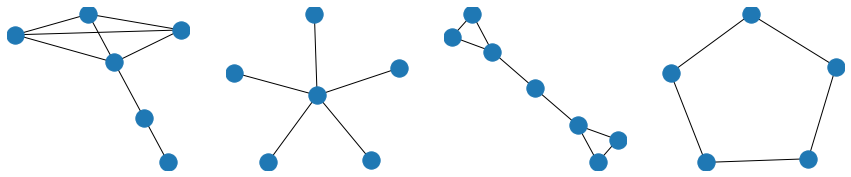

In [11]:
result = Connectivity.fetch('conn_graph', order_by='conn_id')

fig, axx = plt.subplots(1, result.size, figsize=(15, 3))
for g, ax in zip(result, axx.flatten()):
    plt.sca(ax)
    nx.draw(g)